# Result analysis

## Imports and data loading

In [1]:
import xarray as xr
import glob
import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

from google.cloud import storage
import gcsfs
import zarr

import xskillscore as xs
import pandas as pd

import os

import re
import skill_metrics as sm

import matplotlib.lines as mlines

In [34]:
# load all the datasets from the netcdf files and compute into memory
meso_24 = xr.open_dataset('meso_24_processed.nc').compute()
synop_24 = xr.open_dataset('synop_24.nc').compute()
hres_for_24 = xr.open_dataset('hres_for_24.nc').compute()
gc_24_unshifted = xr.open_dataset('gc_24.nc').compute()
gc_24_shifted = xr.open_dataset('gc_24_shifted.nc').compute()
hres_analysis_24 = xr.open_dataset('hres_analysis_24.nc').compute()

# for all the models add wind speed variable
meso_24['10m_wind_speed_meso'] = np.sqrt(meso_24['10m_u_component_of_wind_meso']**2 + meso_24['10m_v_component_of_wind_meso']**2)
synop_24['10m_wind_speed_synop'] = np.sqrt(synop_24['10m_u_component_of_wind_synop']**2 + synop_24['10m_v_component_of_wind_synop']**2)
hres_for_24['10m_wind_speed_hres'] = np.sqrt(hres_for_24['10m_u_component_of_wind_hres']**2 + hres_for_24['10m_v_component_of_wind_hres']**2)
gc_24_unshifted['10m_wind_speed_gc'] = np.sqrt(gc_24_unshifted['10m_u_component_of_wind_gc']**2 + gc_24_unshifted['10m_v_component_of_wind_gc']**2)
gc_24_shifted['10m_wind_speed_gc'] = np.sqrt(gc_24_shifted['10m_u_component_of_wind_gc']**2 + gc_24_shifted['10m_v_component_of_wind_gc']**2)
hres_analysis_24['10m_wind_speed_analysis'] = np.sqrt(hres_analysis_24['10m_u_component_of_wind_analysis']**2 + hres_analysis_24['10m_v_component_of_wind_analysis']**2)

In [4]:
meso_24_nobarometric = xr.open_dataset('meso_24_processed_nobarometric.nc').compute()

meso_24_nobarometric['10m_wind_speed_meso_nobarometric'] = np.sqrt(meso_24_nobarometric['10m_u_component_of_wind_meso_nobarometric']**2 + meso_24_nobarometric['10m_v_component_of_wind_meso_nobarometric']**2)

## Contiguous timeseries

### Timeseries functions

In [13]:
def plot_timeseries_for_station(station, variable, forecast_datasets, observation_dataset, time_range=None, save_path=None):
    """
    Plot a timeseries for a single station and variable containing all forecasts and observations.
    
    Parameters:
    - station (str): The station code to plot the timeseries for.
    - variable (str): The variable to plot the timeseries for.
    - forecast_datasets (dict): A dictionary containing forecast datasets with keys as model names and values as datasets.
    - observation_dataset (xarray.Dataset): The dataset containing the observation data.
    - time_range (tuple, optional): A tuple containing the start and end dates for the time range to plot.
    - save_path (str, optional): Path to save the plot, if provided.
    
    Returns:
    - None
    """
    # Define the models to plot
    models = list(forecast_datasets.keys())

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the observation data with markers and thicker line
    obs_data = observation_dataset[variable + '_synop'].sel(station=station)
    if time_range:
        obs_data = obs_data.sel(valid_time=slice(time_range[0], time_range[1]))
    
    obs_data.plot(ax=ax, label='Synop', color='black', linewidth=1.8, marker='o', markersize=3)

    # Loop through each model and plot the forecast data
    line_styles = [':', '--','-.', '--']  # Different line styles for models
    line_colors = ['green', 'blue', 'orange', 'red']
    for idx, model in enumerate(models):
        forecast_data = forecast_datasets[model][variable + '_' + model].sel(station=station)
        if time_range:
            forecast_data = forecast_data.sel(valid_time=slice(time_range[0], time_range[1]))

        forecast_data.plot(ax=ax, label=model, 
                           linestyle=line_styles[idx % len(line_styles)], 
                           color=line_colors[idx % len(line_colors)],
                           alpha=0.75, linewidth=1)

    # Set the title and labels
    ax.set_title(f'{variable.replace("_", " ").title()} Timeseries for Station {station}', fontsize=14)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel(f'{variable.replace("_", " ").title()}', fontsize=12)

    # Customize the legend
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=10, frameon=False)

    # Add gridlines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Convert time range to datetime objects
    if time_range:
        start_date = pd.to_datetime(time_range[0])
        end_date = pd.to_datetime(time_range[1])
        ax.set_xlim(start_date, end_date)

    # Calculate global min and max values across all datasets for y-axis limits
    global_min = obs_data.min().item()
    global_max = obs_data.max().item()

    for model in models:
        forecast_data = forecast_datasets[model][variable + '_' + model].sel(station=station)
        if time_range:
            forecast_data = forecast_data.sel(valid_time=slice(time_range[0], time_range[1]))

        model_min = forecast_data.min().item()
        model_max = forecast_data.max().item()
        
        global_min = min(global_min, model_min)
        global_max = max(global_max, model_max)

    # Set y limits based on global min and max values
    ax.set_ylim(global_min - 2, global_max + 2)

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Use bbox_inches to prevent legend cutoff
        print(f"Plot saved to {save_path}")

        # if saved, suppress the plot
        plt.close()

    # Show the plot
    plt.show()


### Timeseries generation

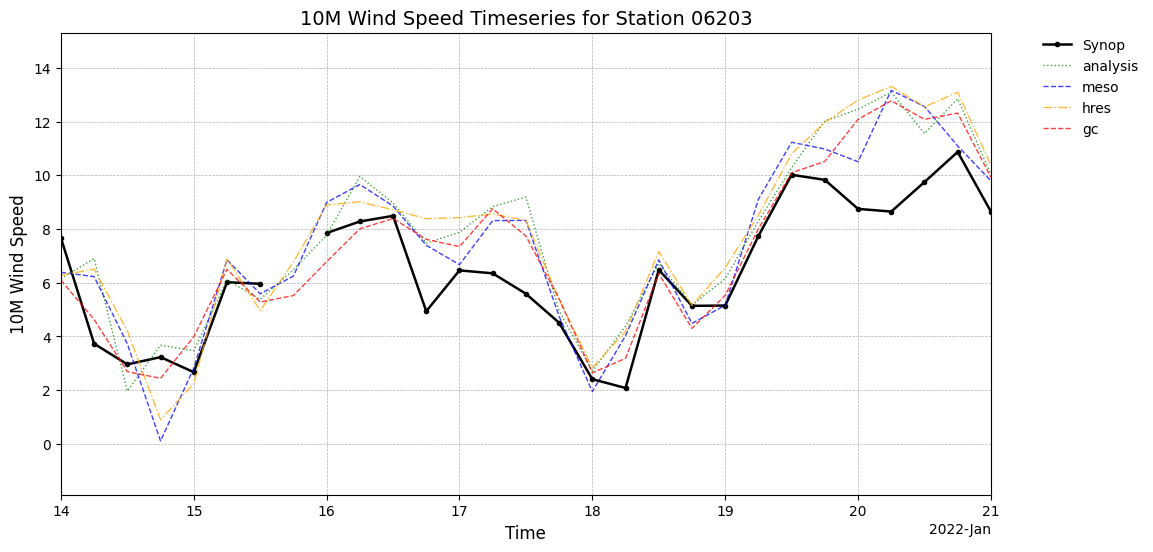

In [36]:
# plot_timeseries_for_station('06240', '10m_wind_speed', {'analysis': hres_analysis_24, 'meso': meso_24, 'hres': hres_for_24,  'gc': gc_24_unshifted}, synop_24, time_range=('2022-01-14', '2022-01-16'))
plot_timeseries_for_station('06203', 
                            '10m_wind_speed', 
                            {'analysis': hres_analysis_24, 
                             'meso': meso_24, 
                             'hres': hres_for_24,  
                             'gc': gc_24_shifted}, 
                             synop_24, 
                             time_range=('2022-01-14', '2022-01-21')
                             )

# plot_timeseries_for_station('06380', '10m_wind_speed', {'meso': meso_24, 'hres': hres_for_24}, synop_24, time_range=('2022-01-12', '2022-1-19'))

### Timeseries to file

In [42]:
# For some random stations

stations = ['06203', '06380'
            # '06207', '06249', '06251',
            # '06257', '06350',  '06377', 
            ]

# for some random week long time ranges in 2022
time_ranges = [('2022-01-14', '2022-01-21'), 
            #    ('2022-02-21', '2022-02-28'), 
            #    ('2022-03-28', '2022-03-04'),
               ('2022-04-11', '2022-04-18'),
            #    ('2022-05-09', '2022-05-16'),
            #     ('2022-06-13', '2022-06-20'),
                ('2022-07-11', '2022-07-18'),
                # ('2022-08-08', '2022-08-15'),
                # ('2022-09-12', '2022-09-19'),
                ('2022-10-10', '2022-10-17'),
                # ('2022-11-14', '2022-11-21'),
                # ('2022-12-12', '2022-12-19')
                ]


# for some variables
variables = ['2m_temperature',
             '10m_wind_speed', 
             'mean_sea_level_pressure'
            ]

for station in stations:
    for variable in variables:
        for time_range in time_ranges:
            save_path = f'timeseries_plots_shifted/{station}_{variable}_{time_range[0]}_{time_range[1]}.png'
            plot_timeseries_for_station(station, 
                                        variable, 
                                        {'analysis': hres_analysis_24, 
                                         'meso': meso_24, 
                                         'hres': hres_for_24,  
                                         'gc': gc_24_shifted}, 
                                         synop_24, 
                                         time_range=time_range,
                                         save_path=save_path
                                        )

Plot saved to timeseries_plots_shifted/06203_2m_temperature_2022-01-14_2022-01-21.png
Plot saved to timeseries_plots_shifted/06203_2m_temperature_2022-04-11_2022-04-18.png
Plot saved to timeseries_plots_shifted/06203_2m_temperature_2022-07-11_2022-07-18.png
Plot saved to timeseries_plots_shifted/06203_2m_temperature_2022-10-10_2022-10-17.png
Plot saved to timeseries_plots_shifted/06203_10m_wind_speed_2022-01-14_2022-01-21.png
Plot saved to timeseries_plots_shifted/06203_10m_wind_speed_2022-04-11_2022-04-18.png
Plot saved to timeseries_plots_shifted/06203_10m_wind_speed_2022-07-11_2022-07-18.png
Plot saved to timeseries_plots_shifted/06203_10m_wind_speed_2022-10-10_2022-10-17.png
Plot saved to timeseries_plots_shifted/06203_mean_sea_level_pressure_2022-01-14_2022-01-21.png
Plot saved to timeseries_plots_shifted/06203_mean_sea_level_pressure_2022-04-11_2022-04-18.png
Plot saved to timeseries_plots_shifted/06203_mean_sea_level_pressure_2022-07-11_2022-07-18.png
Plot saved to timeseries_pl

In [66]:
hres_for_24.sel(station='06380', valid_time='2022-01-13T12:00:00')['10m_wind_speed_hres']

<xarray.DataArray '10m_wind_speed_hres' ()> Size: 4B
array(1.9280239, dtype=float32)
Coordinates:
    time                  datetime64[ns] 8B 2022-01-13
    prediction_timedelta  timedelta64[ns] 8B 12:00:00
    lat                   float64 8B 50.91
    lon                   float64 8B 5.762
    station               <U5 20B '06380'
    valid_time            datetime64[ns] 8B 2022-01-13T12:00:00

RMSE at different forecast hours for 10m_wind_speed

Forecast Hour: 6 hours
RMSE by xskillscore:
  Meso: 1.6548079026870695
  GC:   1.4300449202189043
  HRES: 1.3692576791410753
Forecast Hour: 12 hours
RMSE by xskillscore:
  Meso: 1.8325156933267677
  GC:   1.3772161144618145
  HRES: 1.3665359402843695
Forecast Hour: 18 hours
RMSE by xskillscore:
  Meso: 1.9327313185833437
  GC:   1.4904541204488062
  HRES: 1.5333771461785066


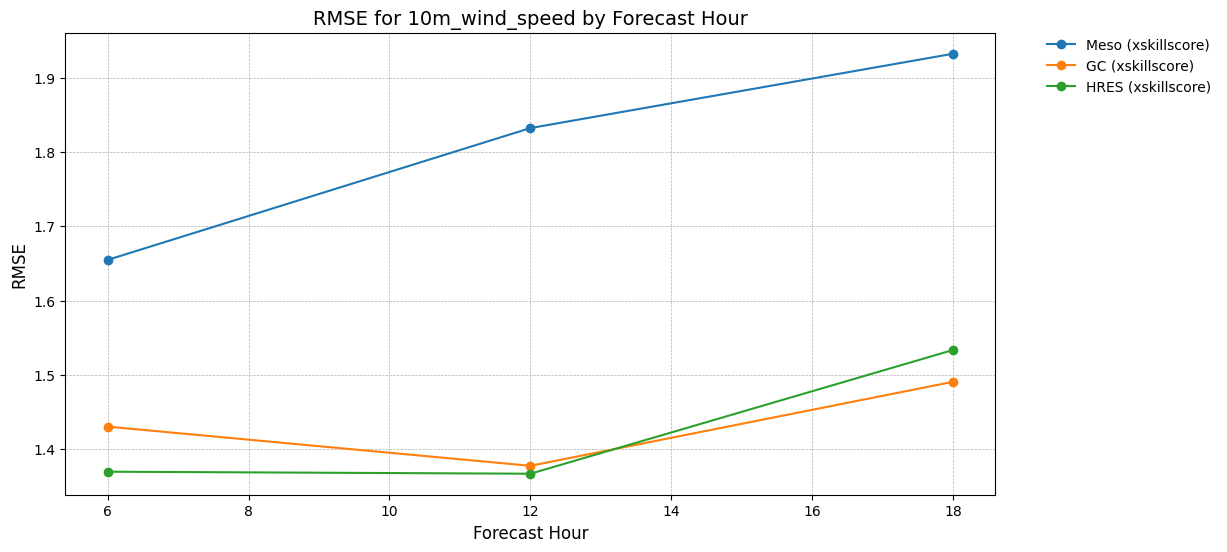

In [58]:
import pandas as pd
import xarray as xr
import xskillscore as xs
import numpy as np

# Define the list of stations
stations = ['06201', '06203', '06204', '06207', '06208', '06211', '06214', '06215',
            '06225', '06229', '06235', '06240', '06242', '06248', '06249', '06251',
            '06257', '06258', '06260', '06267', '06269', '06270', '06273', '06275',
            '06277', '06278', '06279', '06280', '06283', '06286', '06290', '06310',
            '06317', '06319', '06323', '06330', '06340', '06343', '06344', '06348',
            '06350', '06356', '06370', '06375', '06377', '06380', '06212']

# Generate dates from 2022-01-12 to 2022-12-31
dates = pd.date_range(start='2022-01-13', end='2022-12-30', freq='D')

# Define the forecast hours
forecast_hours = [6, 12, 18]

# Define the variable to analyze
variable = '10m_wind_speed'

# Initialize dictionaries to store RMSE results
rmse_meso_xs = {}
rmse_gc_xs = {}
rmse_hres_xs = {}
rmse_meso_hand = {}
rmse_gc_hand = {}
rmse_hres_hand = {}

for fh in forecast_hours:
    # Compute valid times
    valid_times = dates + pd.Timedelta(hours=fh)
    valid_times_str = valid_times.strftime('%Y-%m-%dT%H:%M:%S')
    
    # Select data for all stations and valid_times
    forecast_meso = meso_24[f'{variable}_meso'].sel(valid_time=valid_times_str, station=stations)
    forecast_gc = gc_24_shifted[f'{variable}_gc'].sel(valid_time=valid_times_str, station=stations)
    forecast_hres = hres_for_24[f'{variable}_hres'].sel(valid_time=valid_times_str, station=stations)
    obs = synop_24[f'{variable}_synop'].sel(valid_time=valid_times_str, station=stations)
    
    # Compute RMSE using xskillscore
    rmse_meso_xs[fh] = xs.rmse(forecast_meso, obs, dim=['valid_time', 'station'], skipna=True)
    rmse_gc_xs[fh] = xs.rmse(forecast_gc, obs, dim=['valid_time', 'station'], skipna=True)
    rmse_hres_xs[fh] = xs.rmse(forecast_hres, obs, dim=['valid_time', 'station'], skipna=True)
    
    # Compute RMSE manually
    rmse_meso_hand[fh] = np.sqrt(((forecast_meso - obs) ** 2).mean(skipna=True))
    rmse_gc_hand[fh] = np.sqrt(((forecast_gc - obs) ** 2).mean(skipna=True))
    rmse_hres_hand[fh] = np.sqrt(((forecast_hres - obs) ** 2).mean(skipna=True))

# Print results
print(f'RMSE at different forecast hours for {variable}\n')

for fh in forecast_hours:
    print(f'Forecast Hour: {fh} hours')
    print('RMSE by xskillscore:')
    print(f'  Meso: {rmse_meso_xs[fh].values}')
    print(f'  GC:   {rmse_gc_xs[fh].values}')
    print(f'  HRES: {rmse_hres_xs[fh].values}')
    # print('RMSE computed manually:')
    # print(f'  Meso: {rmse_meso_hand[fh].values}')
    # print(f'  GC:   {rmse_gc_hand[fh].values}')
    # print(f'  HRES: {rmse_hres_hand[fh].values}')
    # print()

# create a plot with the RMSE values as a fuction of forecast hour
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the RMSE values for each forecast hour
ax.plot(forecast_hours, [rmse_meso_xs[fh].values for fh in forecast_hours], label='Meso (xskillscore)', marker='o')
ax.plot(forecast_hours, [rmse_gc_xs[fh].values for fh in forecast_hours], label='GC (xskillscore)', marker='o')
ax.plot(forecast_hours, [rmse_hres_xs[fh].values for fh in forecast_hours], label='HRES (xskillscore)', marker='o')
# ax.plot(forecast_hours, [rmse_meso_hand[fh].values for fh in forecast_hours], label='Meso (manual)', marker='o')
# ax.plot(forecast_hours, [rmse_gc_hand[fh].values for fh in forecast_hours], label='GC (manual)', marker='o')
# ax.plot(forecast_hours, [rmse_hres_hand[fh].values for fh in forecast_hours], label='HRES (manual)', marker='o')

# Set the title and labels
ax.set_title(f'RMSE for {variable} by Forecast Hour', fontsize=14)
ax.set_xlabel('Forecast Hour', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)

# Customize the legend
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=10, frameon=False)

# Add gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()


0.7733647600809731
1.3999453687258185
0.8030658070246376


### NaN values

In [10]:
# List of variables to check for NaN values
variables = [
    '2m_temperature_synop',
    'mean_sea_level_pressure_synop',
    '10m_v_component_of_wind_synop',
    '10m_u_component_of_wind_synop',
    '10m_wind_speed_synop',
    'total_precipitation_6hr_synop'
]

# Initialize an empty DataFrame to store NaN counts
nan_counts_df = pd.DataFrame()

# Loop over each variable and calculate the NaN counts
for var in variables:
    station_nan_counts = synop_24[var].isnull().sum(dim='valid_time')  # Summing over 'valid_time'
    station_nan_counts = station_nan_counts.to_dataframe().reset_index()  # Convert to DataFrame and reset index
    station_nan_counts = station_nan_counts.rename(columns={var: f'nan_count_{var}'})  # Rename column for the variable

    # If the DataFrame is empty, initialize it with the first variable's counts
    if nan_counts_df.empty:
        nan_counts_df = station_nan_counts
    else:
        # Merge the new counts into the existing DataFrame
        nan_counts_df = pd.merge(nan_counts_df, station_nan_counts, on=['station'], how='outer')

# Sort by any specific variable's NaN counts if needed (e.g., '10m_u_component_of_wind_synop')
nan_counts_df_synop = nan_counts_df.sort_values(by='nan_count_10m_u_component_of_wind_synop')

# Display the DataFrame
nan_counts_df_synop.sort_index()


# # write the nan_counts_df to a csv file
# nan_counts_df.to_csv('nan_counts_synop.csv')


,station,nan_count_2m_temperature_synop,nan_count_mean_sea_level_pressure_synop,nan_count_10m_v_component_of_wind_synop,nan_count_10m_u_component_of_wind_synop,nan_count_10m_wind_speed_synop,nan_count_total_precipitation_6hr_synop
0,06201,137,14,161,161,161,1416
1,06203,13,13,18,18,18,1416
2,06204,90,649,90,90,90,1416
3,06207,21,21,21,21,21,1416
4,06208,167,114,90,90,90,1416
5,06211,15,222,15,15,15,1416
6,06212,158,158,729,729,729,1416
7,06214,146,146,147,147,147,1416
8,06215,6,6,6,6,6,22
9,06225,1416,1416,4,4,4,1416


In [70]:
# Find the NaN values for gc_24 per station

# drop lat and lon from the gc_24 dataset
gc_24_nan_processing = gc_24.drop_vars(['lat', 'lon'])
# Variables to check for NaN values
variables = [
    '2m_temperature_gc',
    'mean_sea_level_pressure_gc',
    '10m_v_component_of_wind_gc',
    '10m_u_component_of_wind_gc',
    'total_precipitation_6hr_gc'
]

# Initialize an empty DataFrame to store NaN counts
nan_counts_df = pd.DataFrame()

# Loop over each variable and calculate the NaN counts
for var in variables:
    station_nan_counts = gc_24_nan_processing[var].isnull().sum(dim='valid_time')  # Summing over 'valid_time'
    station_nan_counts = station_nan_counts.to_dataframe().reset_index()  # Convert to DataFrame and reset index
    station_nan_counts = station_nan_counts.rename(columns={var: f'nan_count_{var}'})  # Rename column for the variable

    # If the DataFrame is empty, initialize it with the first variable's counts
    if nan_counts_df.empty:
        nan_counts_df = station_nan_counts
    else:
        # Merge the new counts into the existing DataFrame, specifying suffixes for overlapping columns
        nan_counts_df = pd.merge(
            nan_counts_df, station_nan_counts, 
            on=['station'], 
            how='outer', 
            suffixes=('_left', '_right')  # Adjust these suffixes as needed
        )


# Sort by any specific variable's NaN counts if needed (e.g., '10m_u_component_of_wind_gc')
nan_counts_df_gc = nan_counts_df.sort_values(by='nan_count_10m_u_component_of_wind_gc')

# Display the DataFrame
nan_counts_df_gc.to_csv('nan_counts_gc.csv')

In [102]:
carribean = SYNOP_22.where(SYNOP_22.station.astype(str).str.startswith('7'), drop=True)
print(carribean['lat'].values)
print(carribean['lon'].values)

[[17.6461111 17.4955556 12.13     ]
 [17.6461111 17.4955556 12.13     ]
 [17.6461111 17.4955556 12.13     ]
 ...
 [17.6461111 17.4955556 12.13     ]
 [17.6461111 17.4955556 12.13     ]
 [17.6461111 17.4955556 12.13     ]]
[[-63.2208333 -62.9827778 -68.2758333]
 [-63.2208333 -62.9827778 -68.2758333]
 [-63.2208333 -62.9827778 -68.2758333]
 ...
 [-63.2208333 -62.9827778 -68.2758333]
 [-63.2208333 -62.9827778 -68.2758333]
 [-63.2208333 -62.9827778 -68.2758333]]


### Mean sea level pressure conversion

In [58]:
meso_24_unprocessed = xr.open_dataset('meso_24.nc').compute()
meso_24_unprocessed

<xarray.Dataset> Size: 1MB
Dimensions:                       (index: 48, valid_time: 1416, station: 47)
Coordinates:
  * index                         (index) int32 192B 0 1 2 3 4 ... 44 45 46 47
  * station                       (station) <U5 940B '06201' '06203' ... '06212'
    time                          (valid_time) datetime64[ns] 11kB 2022-01-12...
    prediction_timedelta          (valid_time) timedelta64[ns] 11kB 06:00:00 ...
  * valid_time                    (valid_time) datetime64[ns] 11kB 2022-01-12...
Data variables:
    total_precipitation_6hr_meso  (index, valid_time) float32 272kB 0.0 ... 0.0
    2m_temperature_meso           (index, valid_time) float32 272kB 7.58 ... ...
    10m_u_component_of_wind_meso  (index, valid_time) float32 272kB 6.603 ......
    10m_v_component_of_wind_meso  (index, valid_time) float32 272kB 1.233 ......
    mean_sea_level_pressure_meso  (index, valid_time) float32 272kB 1.027e+03...